### Dane z https://github.com/furqan4545/handwritten_text_detection_and_recognition.git

In [5]:
from word_detector import prepare_img, detect, sort_line
import matplotlib.pyplot as plt
import cv2
import numpy as np

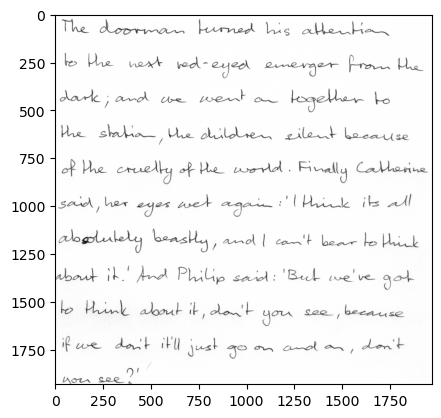

In [6]:
# img = prepare_img(cv2.imread('data/line/0.png'), 50)
img = cv2.imread('data/page/r06-137.png')
img = prepare_img(img, img.shape[0])
# (2) detect words in image
detections = detect(img,
                    kernel_size=25,
                    sigma=11,
                    theta=7,
                    min_area=100)

# (3) sort words in line
line = sort_line(detections)[0]

# (4) show word images
plt.imshow(img, cmap='gray')

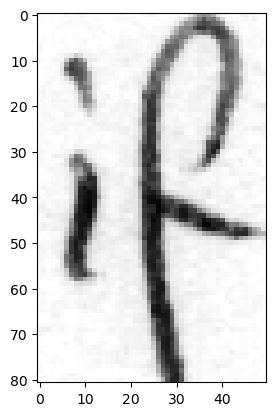

In [7]:
# plt.subplot(len(line), 1, 1)
# for i, word in enumerate(line):
#   print(word.bbox)
#   plt.subplot(len(line), 1, i + 1)
#   plt.imshow(word.img, cmap='gray')
# plt.savefig('line.png')
plt.imshow(line[0].img, cmap='gray')

In [8]:
from transformer import *

Using device: cuda
Using device: cuda


In [9]:
augument = transforms.Compose([
    transforms.RandomRotation(15, expand=True, fill=(255,)),
    transforms.RandomAffine(0, translate=(0.05, 0.05), fill=(255,)),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5, fill=(255,)),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
])

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 128)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 1.0 - x),
    transforms.Normalize((0.5,), (0.5,)),
])

In [10]:
# train_dataset = HandWritingDataset('words_data/train', transform=transform, label_transofrm=Params.encode_string, augument=augument) # augument data
train_dataset = H5Dataset('train_data.h5', num_epochs=1)
val_dataset = HandWritingDataset(root='words_data/val', transform=transform, label_transofrm=Params.encode_string)

train_loader = DataLoader(train_dataset, batch_size=64, num_workers=0, sampler=train_dataset.create_h5_sampler(0), collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=0, shuffle=True, collate_fn=collate_fn)

model = HandwritingTransformer(
    input_size=16 * 24,
    vocab_size=len(Params.vocab)+2,
    d_model=128,
    nhead_en=1,
    num_layers_en=1,
    nhead_de=1,
    num_layers_de=1,
    dropout=0.2
).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
early_stopping = EarlyStopping(patience=5)
history = TrainingHistory()

d:\Anaconda\envs\handwriting_recognition\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\envs\handwriting_recognition\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
train(
    model=model,
    train_loader=val_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=1,
    early_stopping=early_stopping,
    history=history
)

Epoch:     1/1 100% | Elapsed:   2s | loss: 2.4924 - acc: 0.1339 | val_loss: 1.9871 - val_acc: 0.1841


In [12]:
test_dataset = HandWritingDataset(root='words_data/val', transform=transform, label_transofrm=Params.encode_string)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0, shuffle=True, collate_fn=collate_fn)

val_with_outs = ValidatorWithOutputs(model, criterion, device)
outputs = val_with_outs.validate(test_loader)

for i, (predicted, expected) in enumerate(outputs):
    if i > 100:
        break
    predicted = Params.decode_string([i for i in predicted if i not in [27, 28]])
    expected = Params.decode_string([i for i in expected if i not in [27, 28]])
    print(f"{predicted.ljust(12)}  -  {expected.ljust(12)}")

an            -  in          
aoni          -  now         
oo            -  get         
ponhen        -  nothing     
aeaei         -  reference   
tan           -  like        
ao            -  no          
andii         -  answered    
a             -  as          
aann          -  said        
th            -  to          
ahe           -  where       
the           -  the         
ooe           -  they        
ah            -  sell        
pndesn        -  inquiry     
of            -  of          
aonenon       -  capacity    
aannden       -  household   
to            -  not         
o             -  is          
ahn           -  would       
in            -  is          
o             -  a           
tunh          -  battle      
aen           -  hold        
aa            -  end         
tet           -  buy         
of            -  you         
aeahne        -  returned    
anee          -  arms        
an            -  are         
aoen          -  from        
th        

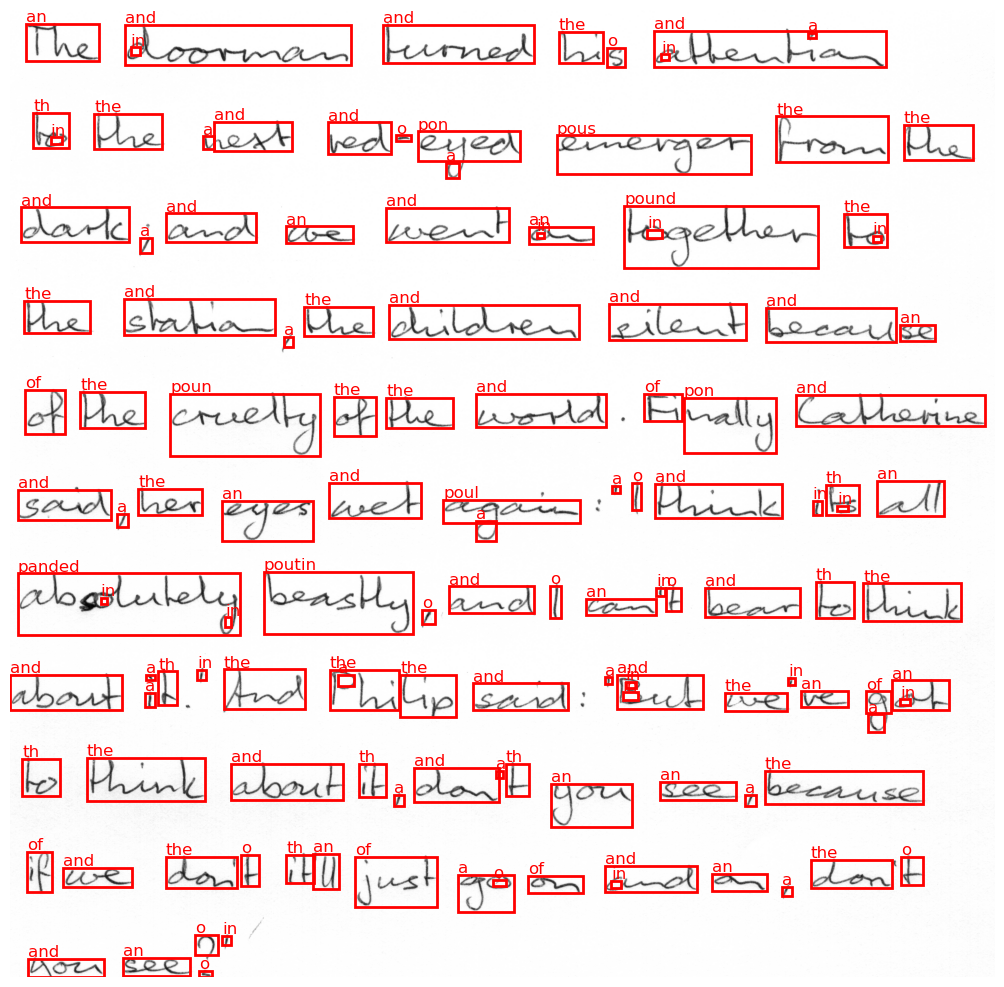

In [13]:
# Process detections through the handwriting recognition model
def predict_from_detections(detections, model, transform):
    model.eval()
    results = []
    
    with torch.no_grad():
        for det in detections:
            # Convert the detected word image to PIL format
            word_img = Image.fromarray(det.img)
            
            # Apply the same transformations used during training
            img_tensor = transform(word_img).unsqueeze(0).to(device)
            
            # Start with the SOS token
            input_token = torch.tensor([[27]]).to(device)
            
            # Generate tokens one by one
            generated_tokens = [27]  # Start with SOS token
            max_length = 20  # Set maximum word length
            
            for _ in range(max_length):
                output = model(img_tensor, input_token)
                next_token = output[0, -1].argmax().item()
                generated_tokens.append(next_token)
                
                # Stop if we reach EOS token
                if next_token == 28:
                    break
                
                # Update input token for next prediction
                input_token = torch.cat([input_token, torch.tensor([[next_token]]).to(device)], dim=1)
            
            # Convert tokens to text
            pred_text = Params.decode_string([i for i in generated_tokens if i not in [27, 28]])
            results.append((det.bbox, pred_text))
    
    return results

# Run predictions on detections
predictions = predict_from_detections(detections, model, transform)

# Display results with bounding boxes and predicted text
plt.figure(figsize=(15, 10))
plt.imshow(img, cmap='gray')

for bbox, text in predictions:
    plt.gca().add_patch(plt.Rectangle((bbox.x, bbox.y), bbox.w, bbox.h, 
                                     fill=False, edgecolor='red', linewidth=2))
    plt.text(bbox.x, bbox.y-5, text, color='red', fontsize=12)

plt.axis('off')
plt.tight_layout()
plt.show()